In [1]:
import numpy as np
from numpy import linalg as LA
from ncon import ncon
from scipy.linalg import expm

# Apply Gate Step

In [2]:
def apply_gate_MPS(gateAB, A, sAB, B, sBA, chi, stol=1e-7):
    """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
    some desired dimension chi"""

    # ensure singular values are above tolerance threshold
    sBA_trim = sBA * (sBA > stol) + stol * (sBA < stol)

    # contract gate into the MPS, then deompose composite tensor with SVD
    d = A.shape[1]
    chiBA = sBA_trim.shape[0]
    tensors = [np.diag(sBA_trim), A, np.diag(sAB), B, np.diag(sBA_trim), gateAB]
    connects = [[-1, 1], [1, 5, 2], [2, 4], [4, 6, 3], [3, -4], [-2, -3, 5, 6]]
    nshape = [d * chiBA, d * chiBA]
    utemp, stemp, vhtemp = LA.svd(ncon(tensors, connects).reshape(nshape),
                                full_matrices=False)

    # truncate to reduced dimension
    chitemp = min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)].reshape(sBA_trim.shape[0], d * chitemp)
    vhtemp = vhtemp[range(chitemp), :].reshape(chitemp * d, chiBA)

    # remove environment weights to form new MPS tensors A and B
    A = (np.diag(1 / sBA_trim) @ utemp).reshape(sBA_trim.shape[0], d, chitemp)
    B = (vhtemp @ np.diag(1 / sBA_trim)).reshape(chitemp, d, chiBA)

    # new weights
    sAB = stemp[range(chitemp)] / LA.norm(stemp[range(chitemp)])

    return A, sAB, B

In [3]:
d = 2
chi = 16
sAB = np.ones(chi) / np.sqrt(chi)
sBA = np.ones(chi) / np.sqrt(chi)
A = np.random.rand(chi, d, chi)
B = np.random.rand(chi, d, chi)

In [4]:
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0, -1]])
hamAB = (np.real(np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)
hamBA = (np.real(np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)

In [5]:
evotype = "real"

In [6]:
tau = 0.1  # timestep

In [7]:
# exponentiate Hamiltonian
if evotype == "real":
    gateAB = expm(1j * tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
    gateBA = expm(1j * tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)
elif evotype == "imag":
    gateAB = expm(-tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
    gateBA = expm(-tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)

In [8]:
A_new, sAB_new, B_new = apply_gate_MPS(gateAB, A, sAB, B, sBA, chi)

In [9]:
tensors = [np.diag(sBA), A, np.diag(sAB), B, np.diag(sBA), gateAB]

In [10]:
connects = [[-1, 1], [1, 5, 2], [2, 4], [4, 6, 3], [3, -4], [-2, -3, 5, 6]]

In [11]:
x = ncon(tensors, connects)

In [12]:
x.shape

(16, 2, 2, 16)

Try to do the same contraction with QUIMB.

In [13]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

In [14]:
data = qu.bell_state('psi-').reshape(2, 2)
inds = ('k0', 'k1')
tags = ('KET',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket

Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET']))

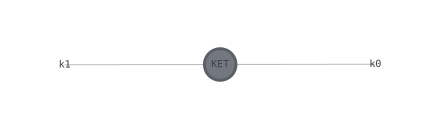

In [15]:
ket.draw()

In [16]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags=['PAULI', 'X', '0'])
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags=['PAULI', 'Y', '1'])

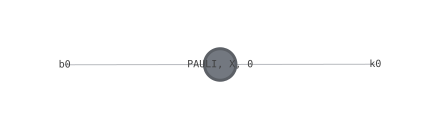

In [17]:
X.draw()

In [18]:
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags=['BRA'])

In [19]:
TN = ket.H & X & Y & bra
print(TN)

TensorNetwork([
    Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET'])),
    Tensor(shape=(2, 2), inds=('k0', 'b0'), tags=oset(['PAULI', 'X', '0'])),
    Tensor(shape=(2, 2), inds=('k1', 'b1'), tags=oset(['PAULI', 'Y', '1'])),
    Tensor(shape=(2, 2), inds=('b0', 'b1'), tags=oset(['BRA'])),
])


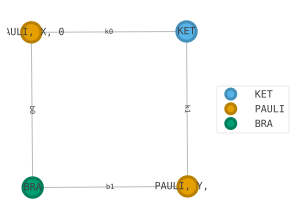

In [20]:
TN.draw(color=['KET', 'PAULI', 'BRA'], figsize=(4, 4), show_inds='all')

In [21]:
TNc = TN ^ ...
TNc

(-0.1342767846150239+0.06313597255863664j)

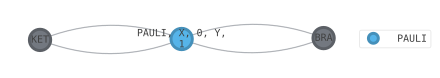

TensorNetwork([
    Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET'])),
    Tensor(shape=(2, 2), inds=('b0', 'b1'), tags=oset(['BRA'])),
    Tensor(shape=(2, 2, 2, 2), inds=('k0', 'b0', 'k1', 'b1'), tags=oset(['PAULI', 'X', '0', 'Y', '1'])),
])


In [22]:
TNc = TN ^ 'PAULI'
TNc.draw('PAULI')
print(TNc)

Create the tensor network corresponding to the update step.

In [23]:
sBA_1_tensor = qtn.Tensor(np.diag(sBA), inds=('f0', 'k1'), tags=['sBA', '1'])
A_tensor = qtn.Tensor(A, inds=('k1', 'k2', 'k3'), tags=['A'])
sAB_tensor = qtn.Tensor(np.diag(sAB), inds=('k3', 'k4'), tags=['sAB'])
B_tensor = qtn.Tensor(B, inds=('k4', 'k5', 'k6'), tags=['B'])
sBA_2_tensor = qtn.Tensor(np.diag(sBA), inds=('k6', 'f3'), tags=['sBA', '2'])
gate_AB_tensor = qtn.Tensor(gateAB, inds=('f1', 'f2', 'k2', 'k5'), tags=['gateAB'])

In [24]:
TN = sBA_1_tensor & gate_AB_tensor & A_tensor & sAB_tensor & B_tensor & sBA_2_tensor

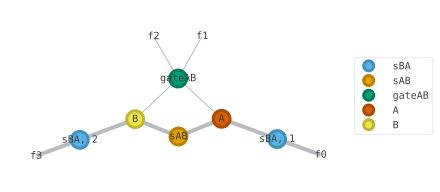

In [25]:
fig = TN.draw(color=['sBA', 'sAB', 'gateAB', 'A', 'B'], return_fig=True)
fig.savefig('apply_gate_step.png', bbox_inches='tight', dpi=300)

In [26]:
TNc = TN ^ ...

In [27]:
np.abs(TNc.data - x).max()

0.0

# SVD

Try to replicate the SVD step.

In [28]:
nshape = [d * chi, d * chi]
nshape

[32, 32]

In [29]:
utemp, stemp, vhtemp = LA.svd(x.reshape(nshape), full_matrices=False)

In [30]:
utemp.shape

(32, 32)

In [31]:
stemp.shape

(32,)

In [32]:
vhtemp.shape

(32, 32)

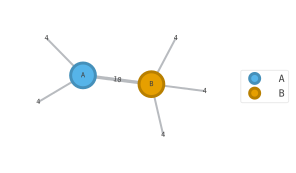

In [33]:
ta = qtn.rand_tensor([4, 4, 10], ['a', 'b', 'c'], 'A')
tb = qtn.rand_tensor([10, 4, 4, 4], ['c', 'd', 'e', 'f'], 'B')
(ta | tb).draw(['A', 'B'], figsize=(4, 4), show_inds='bond-size')

In [34]:
# perform the compression
qtn.tensor_compress_bond(ta, tb, max_bond=2, absorb='left')

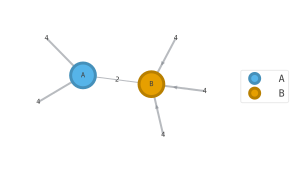

In [35]:
# should now see the bond has been reduced in size to 2
(ta | tb).draw(['A', 'B'], figsize=(4, 4), show_inds='bond-size')

# Local Density Matrices

Look at computing the local density matrix

In [36]:
def loc_density_MPS(A, sAB, B, sBA):
    """ Compute the local reduced density matrices from an MPS (assumend to be
    in canonical form)."""

    # recast singular weights into a matrix
    mAB = np.diag(sAB)
    mBA = np.diag(sBA)

    # contract MPS for local reduced density matrix (A-B)
    tensors = [np.diag(sBA**2), A, A.conj(), mAB, mAB, B, B.conj(),
             np.diag(sBA**2)]
    connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
    rhoAB = ncon(tensors, connects)

    # contract MPS for local reduced density matrix (B-A)
    tensors = [np.diag(sAB**2), B, B.conj(), mBA, mBA, A, A.conj(),
             np.diag(sAB**2)]
    connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
    rhoBA = ncon(tensors, connects)

    return rhoAB, rhoBA

In [37]:
mAB = np.diag(sAB)
mBA = np.diag(sBA)

In [38]:
rhoAB, rhoBA = loc_density_MPS(A, sAB, B, sBA)

In [39]:
sBA_1_tensor = qtn.Tensor(np.diag(sBA**2), inds=('k3', 'k4'), tags=['sBA', '1'])
A_tensor = qtn.Tensor(A, inds=('k3', 'f3', 'k1'), tags=['A'])
A_conj_tensor = qtn.Tensor(A.conj(), inds=('k4', 'f1', 'k2'), tags=['A_conj'])
mAB_1_tensor = qtn.Tensor(mAB, inds=('k1', 'k7'), tags=['mAB', '1'])
mAB_2_tensor = qtn.Tensor(mAB, inds=('k2', 'k8'), tags=['mAB', '2'])
B_tensor = qtn.Tensor(B, inds=('k7', 'f4', 'k5'), tags=['B'])
B_conj_tensor = qtn.Tensor(B.conj(), inds=('k8', 'f2', 'k6'), tags=['B_conj'])
sBA_2_tensor = qtn.Tensor(np.diag(sBA**2), inds=('k5', 'k6'), tags=['sBA', '2'])

In [40]:
TN_rhoAB = (
    sBA_1_tensor & A_tensor & A_conj_tensor & mAB_1_tensor & mAB_2_tensor & B_tensor & B_conj_tensor & sBA_2_tensor
)

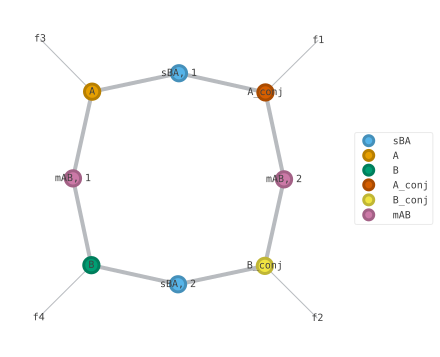

In [41]:
fig = TN_rhoAB.draw(color=['sBA', 'A', 'B', 'A_conj', 'B_conj', 'mAB'], return_fig=True)
fig.savefig('../figures/local_density_matrix.png', bbox_inches='tight', dpi=300)

In [42]:
TN_rhoAB = TN_rhoAB ^ ...
TN_rhoAB

Tensor(shape=(2, 2, 2, 2), inds=('f3', 'f1', 'f4', 'f2'), tags=oset(['sBA', '1', 'A', 'A_conj', 'mAB', '2', 'B', 'B_conj']))

In [43]:
rhoAB_quimb = TN_rhoAB.transpose('f1', 'f2', 'f3', 'f4').data

In [44]:
np.abs(rhoAB_quimb - rhoAB).max()

4.440892098500626e-16

In [45]:
sAB_1_tensor = qtn.Tensor(np.diag(sAB**2), inds=('k3', 'k4'), tags=['sAB', '1'])
B_tensor = qtn.Tensor(B, inds=('k3', 'f3', 'k1'), tags=['B'])
B_conj_tensor = qtn.Tensor(B.conj(), inds=('k4', 'f1', 'k2'), tags=['B_conj'])
mBA_1_tensor = qtn.Tensor(mAB, inds=('k1', 'k7'), tags=['mBA', '1'])
mBA_2_tensor = qtn.Tensor(mAB, inds=('k2', 'k8'), tags=['mBA', '2'])
A_tensor = qtn.Tensor(A, inds=('k7', 'f4', 'k5'), tags=['A'])
A_conj_tensor = qtn.Tensor(A.conj(), inds=('k8', 'f2', 'k6'), tags=['A_conj'])
sAB_2_tensor = qtn.Tensor(np.diag(sAB**2), inds=('k5', 'k6'), tags=['sAB', '2'])

In [46]:
TN_rhoBA = (
    sAB_1_tensor & B_tensor & B_conj_tensor & mBA_1_tensor & mBA_2_tensor & A_tensor & A_conj_tensor & sAB_2_tensor
)

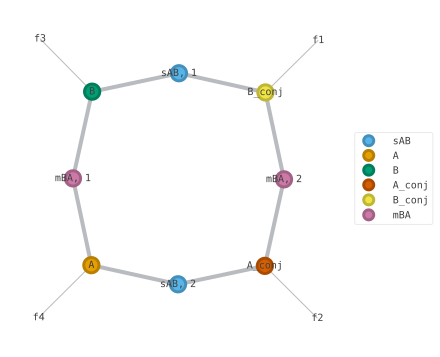

In [47]:
TN_rhoBA.draw(color=['sAB', 'A', 'B', 'A_conj', 'B_conj', 'mBA'])

In [48]:
TN_rhoBA = TN_rhoBA ^ ...
TN_rhoBA

Tensor(shape=(2, 2, 2, 2), inds=('f3', 'f1', 'f4', 'f2'), tags=oset(['sAB', '1', 'B', 'B_conj', 'mBA', '2', 'A', 'A_conj']))

In [49]:
rhoBA_quimb = TN_rhoBA.transpose('f1', 'f2', 'f3', 'f4').data

In [50]:
np.abs(rhoBA_quimb - rhoBA).max()

5.551115123125783e-16

# Energy

In [51]:
energyAB = ncon([hamAB, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]])
energyBA = ncon([hamBA, rhoBA], [[1, 2, 3, 4], [1, 2, 3, 4]])
energy = 0.5 * (energyAB + energyBA)

In [52]:
energy

3.7063398529987386

In [53]:
hamAB_tensor = qtn.Tensor(hamAB, inds=('k1', 'k2', 'k3', 'k4'), tags=['hamAB'])
rhoAB_tensor = qtn.Tensor(rhoAB, inds=('k1', 'k2', 'k3', 'k4'), tags=['rhoAB'])
energyAB_tensor = hamAB_tensor & rhoAB_tensor

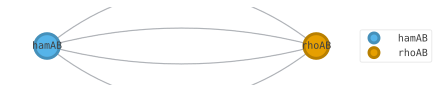

In [54]:
fig = energyAB_tensor.draw(color=['hamAB', 'rhoAB'], return_fig=True)
fig.savefig('../figures/average_energy.png', bbox_inches='tight', dpi=300)

In [55]:
energyAB_tensor ^ ...

3.7198758985939344

In [56]:
energyAB

array(3.7198759)

In [57]:
hamBA_tensor = qtn.Tensor(hamBA, inds=('k1', 'k2', 'k3', 'k4'), tags=['hamBA'])
rhoBA_tensor = qtn.Tensor(rhoBA, inds=('k1', 'k2', 'k3', 'k4'), tags=['rhoBA'])
energyBA_tensor = hamBA_tensor & rhoBA_tensor

In [58]:
energyBA_tensor ^ ...

3.6928038074035427

In [59]:
energyBA

array(3.69280381)